In [58]:
import torch

from pytorch_lightning import Trainer

from models.configurations import TEXT_PRETRAINED, VISION_PRETRAINED
from models.finetuner import AdaptorFinetuner
from models.segmenter import AdaptorSegmenter
from models.adaptor import Adaptor
from utils.model_utils import get_newest_ckpt
from dataset.dataset import clf_collator
from dataset.configurations import DATASET_CFG
from dataset.data_module import AdaptorDataModule#
from utils.model_utils import load_vision_model

import numpy as np

In [57]:
vision_model = "dinov2-b"
text_model = "cxrbert"
# dataset = "rsna"
dataset = "siim"

vision_model_config = VISION_PRETRAINED[vision_model]
vision_pretrained = vision_model_config["pretrained_weight"]
vision_model_type = vision_model_config["vision_model_type"]

# dataset_cfg = DATASET_CFG["clf"][dataset]
dataset_cfg = DATASET_CFG["seg"][dataset]
dataset_class = dataset_cfg["class"]
dataset_kwargs = dataset_cfg["kwargs"]
data_transform = vision_model_config["data_transform"]

data_module = AdaptorDataModule(
    dataset=dataset_class,
    collate_fn=clf_collator,
    transforms=data_transform,
    data_pct=1.0,
    batch_size=16,
    num_workers=1,
    crop_size=224,
    seed=1117,
    **dataset_kwargs,
)
data_module.setup(stage="test")

test_dataset = data_module.datasets['test']#.shuffle(seed=42)
loader = torch.utils.data.DataLoader(test_dataset, batch_size=data_module.batch_size, num_workers=1, collate_fn=clf_collator)

In [40]:
adaptor_ckpt = get_newest_ckpt(
    vision_model, text_model, postfix="v2", 
    project_name="adaptor_pretrain_2_layers", 
)

adaptor = Adaptor.load_from_checkpoint(adaptor_ckpt)
backbone = load_vision_model(
    vision_model_type=vision_model_type,
    vision_pretrained=vision_pretrained,
    retain_head=False,
)

# model = AdaptorFinetuner(
#     backbone=backbone,
#     adaptor=adaptor,
#     model_name=vision_model,
#     text_model_name=None,
#     in_features=adaptor.projection_dim,
#     num_classes=dataset_cfg["num_classes"],
#     # num_layers=args.num_layers,
#     hidden_dim=768,
#     dropout=0.1,
#     learning_rate=1e-4,
#     weight_decay=1e-4,
#     binary=dataset_cfg["binary"],
#     multilabel=dataset_cfg["multilabel"],
# )
model = AdaptorSegmenter(
    seg_model=
)

model.linear_layer = torch.nn.Identity()
model.eval()

trainer = Trainer(
    precision=16, 
    max_epochs=1, 
    
)

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [41]:
from tqdm import tqdm
from math import ceil


n_samples = 1600
total_steps = ceil(n_samples//data_module.batch_size)
i = 0

print(total_steps)

pre_adaptor_embeddings_list = [] 
embeddings_list = []
labels_list = []

# Ensure no gradients are computed
with torch.no_grad():
    for batch in tqdm(loader, total=total_steps):
        
        if i == total_steps:
            break
        # Extract data from batch (depends on your data format)
        inputs, labels = batch['pixel_values'], batch['labels']
        # Move inputs to device (GPU if available)
        inputs = inputs.to(model.device)
        # Get embeddings
        pre_adaptor_embeddings = model.backbone(inputs)
        embeddings = model.adaptor(pre_adaptor_embeddings)
        # Convert embeddings to numpy and store
        pre_adaptor_embeddings_list.append(pre_adaptor_embeddings.cpu().numpy())
        embeddings_list.append(embeddings.cpu().numpy())
        labels_list.append(labels.cpu().numpy())
        
        i += 1

100


 25%|██▌       | 25/100 [00:32<01:38,  1.31s/it]


In [42]:
all_pre_adaptor_embeddings = np.concatenate(pre_adaptor_embeddings_list, axis=0)
all_embeddings = np.concatenate(embeddings_list, axis=0)
labels = np.concatenate(labels_list, axis=0)

# Save embeddings to .npy file
# np.save('embeddings.npy', all_embeddings)

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np

def apply_pca_then_tsne(data, n_pca_components=50, perplexity=40, n_iter=5000, random_state=1117):
    # Apply PCA first
    pca = PCA(n_components=n_pca_components, random_state=random_state)
    pca_result = pca.fit_transform(data)
    
    # Then apply t-SNE
    tsne = TSNE(n_components=2, random_state=random_state, verbose=1, perplexity=perplexity, n_iter=n_iter)
    tsne_result = tsne.fit_transform(pca_result)
    
    return tsne_result

# Apply PCA then t-SNE on all embeddings
tsne_results = apply_pca_then_tsne(all_embeddings, 100, 100)

# Apply PCA then t-SNE on all pre-adaptor embeddings
raw_tsne_results = apply_pca_then_tsne(all_pre_adaptor_embeddings, 10)

print(f"Shape of tsne_results: {tsne_results.shape}")
print(f"Shape of raw_tsne_results: {raw_tsne_results.shape}")
print(f"Shape of labels: {labels.shape}")

# Combine results into a DataFrame
tsne_df = pd.DataFrame({
    'x': tsne_results[:, 0],
    'y': tsne_results[:, 1],
    'x_raw': raw_tsne_results[:, 0],
    'y_raw': raw_tsne_results[:, 1],
    'labels': labels.flatten()
})

# Check if the DataFrame was created successfully
print(tsne_df.head())


[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.188s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.464418
[t-SNE] KL divergence after 100 iterations with early exaggeration: 46.029007
[t-SNE] KL divergence after 950 iterations: 0.887360
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.001s...
[t-SNE] Computed neighbors for 400 samples in 0.014s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 2.972105
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.275517
[t-SNE] KL divergence after 1600 iterations: 0.952180
Shape of tsne_results: (400, 2)
Shape of raw_tsne_results: (400, 2)
Shape of labels: (400, 1)
          x         y      x_raw      y_raw  labels
0 -3.731540 -0.314753   7.357511 -11.506687     2.0
1 -7.402803  0.828212 -15.400976  -6.337430     2.0
2  0.832261 -0.612248

<AxesSubplot:xlabel='x_raw', ylabel='y_raw'>

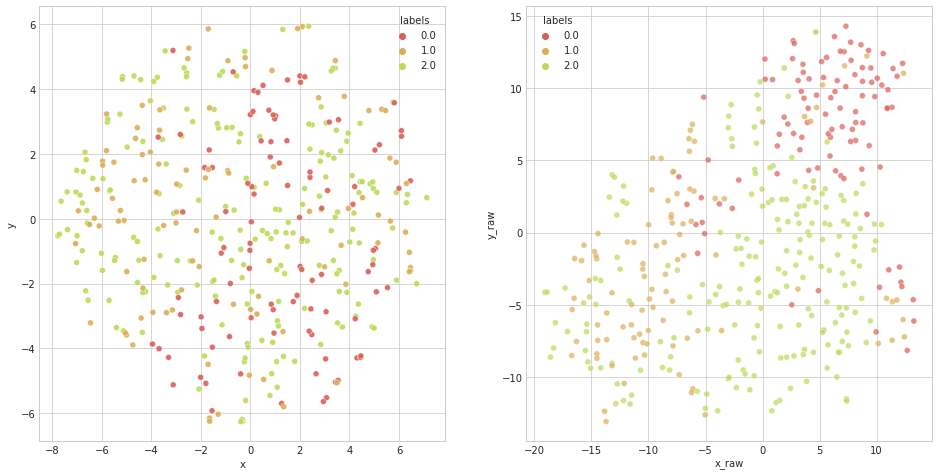

In [54]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(16, 8))

sns.scatterplot(
    x="x", y="y",
    hue="labels",
    palette=sns.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    alpha=0.9, 
    ax=ax[0]
)

sns.scatterplot(
    x="x_raw", y="y_raw",
    hue="labels",
    palette=sns.color_palette("hls", 10),
    data=tsne_df,
    legend="full",
    alpha=0.7, 
    ax=ax[1]
)

In [62]:
import numpy as np
from scipy.stats import entropy

def compute_average_entropy(feature_matrix, n_bins=100):
    """
    Compute the average entropy across all features in the feature matrix.
    
    Parameters:
    - feature_matrix (np.ndarray): An array of shape (num_samples, num_features)
    
    Returns:
    - float: average entropy across all features
    """
    num_samples, num_features = feature_matrix.shape
    average_entropy = 0
    
    # Normalize each feature
    normalized_features = (feature_matrix - np.mean(feature_matrix, axis=0)) / np.std(feature_matrix, axis=0)
    
    for i in range(num_features):
        # Compute histogram for the feature
        hist, _ = np.histogram(normalized_features[:, i], bins=n_bins, density=True)
        
        # Filter out zero values to avoid log(0)
        hist = hist[hist > 0]
        
        # Compute entropy for the feature and add to the total
        average_entropy += entropy(hist)
    
    return average_entropy / num_features

# Example usage:
feature_matrix =  all_embeddings
avg_entropy = compute_average_entropy(feature_matrix)
print(f"Average Entropy: {avg_entropy}")


Average Entropy: 4.14296558998332


In [63]:
feature_matrix =  all_pre_adaptor_embeddings
avg_entropy = compute_average_entropy(feature_matrix)
print(f"Average Entropy: {avg_entropy}")

Average Entropy: 3.944915176555805
